#Import lib and Generate_dataset class

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
from scipy.special import factorial
# m: no of samples 
# n : no of features

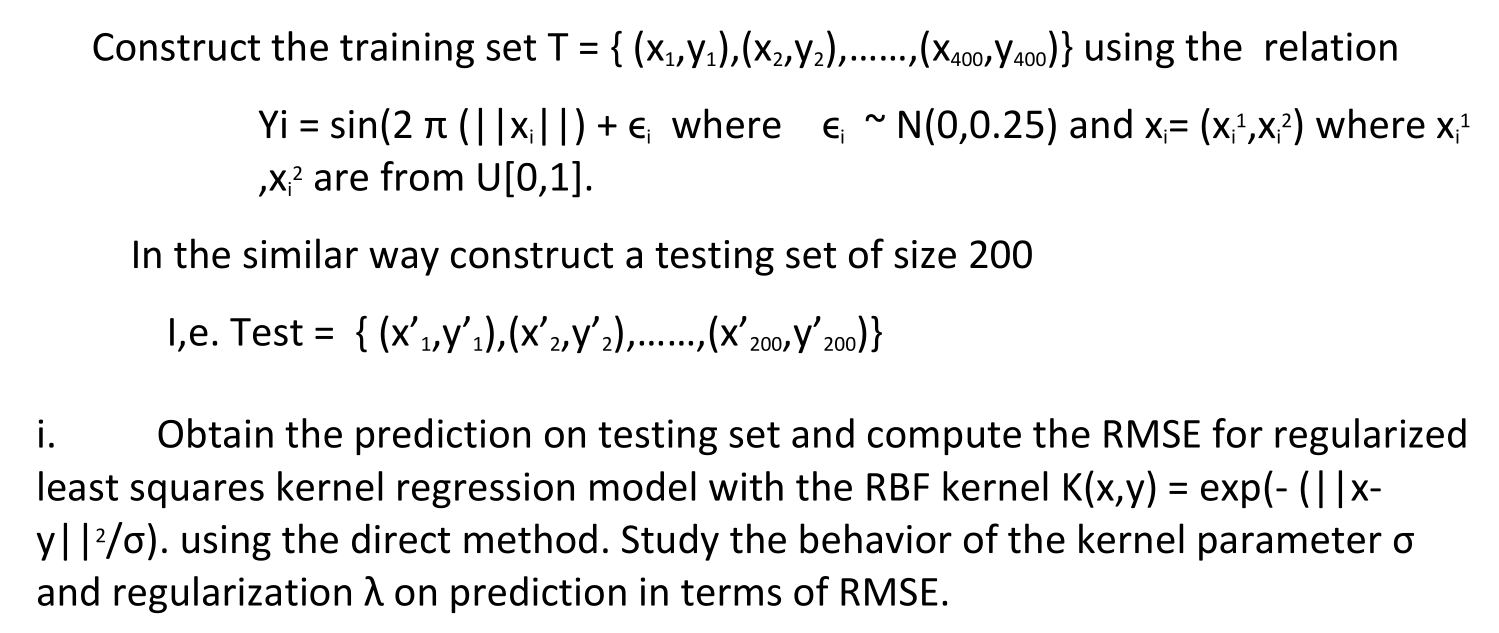

In [ ]:
class Generate_dataset:

  def getTrainSet(self, m, n):
    # sort will help to plot data properly 
    X = np.sort(np.random.uniform(0.0, 1.0, (m*n))).reshape(m, n)
    return X

  def getTestSet(self, X):
    m = X.shape[0]
    ep = np.random.normal(loc=0.0, scale =0.25, size =m) # eplsilon
    y = np.array([np.sin(2*np.pi*np.linalg.norm(X[i]))+ ep[i] for i in range(m)]).reshape(m,1)

    return y
    


#SVR class

In [ ]:
class SVR:
  def rbf_kernal_fun(self, x,y):
    sigma= 1.2
    K = np.exp(-(1 / (sigma**2)) * np.sum((x-y)**2))
    #K = np.exp(-(1 / (sigma**2)) * np.linalg.norm(((x-y))**2))
    return K

  def construct_kernel_matrix(self, x1, x2):

    # applying kernel fun to each combinations of test set samples 
    K = np.zeros((x1.shape[0],x2.shape[0]))
    for i in range(x1.shape[0]):
      for j in range(x2.shape[0]):
        K[i,j] = self.rbf_kernal_fun(x1[i,:], x2[j,:])
    
    # K : n x n
    return K

    ''' 
    # X : m * n
    #||x-y||^2 = ||x||^2 + ||y||^2 - 2 * x * y^T : optimized way
    # https://stackoverflow.com/questions/47271662/what-is-the-fastest-way-to-compute-an-rbf-kernel-in-python

    X_norm = np.sum(X ** 2, axis = 1)
    K = np.exp(- (1/(sigma**2)) * (X_norm[:,None] + X_norm[None,:] - 2 * (X @ X.T)))'''

  def fit_direct(self, X,y, lamda):
    #x1 = X[:, 0].reshape((X.shape[0],1))
    #x2 = X[:, 1].reshape((X.shape[0],1))
    K = self.construct_kernel_matrix(X,X)
    I = np.identity(X.shape[0]+1) #np.eye(np.size( K , 1))

    #add col at end bias
    K = np.insert(K, -1, 1, axis=1) 
    
    theta = np.linalg.pinv( (K.T @ K) + (lamda * I )) @ (K.T @ y)

    return K, theta

  def predict_direct(self, xTest, xTrain, theta):

    K = self.construct_kernel_matrix(xTest,xTrain)
    # for bias insert 1 extra col of 1s at last col
    K = np.insert(K, -1, 1, axis=1) 
    
    Y_pred = K @ theta

    return Y_pred


  def find_rmse(self, y, y_pred):
    x = np.sqrt(np.mean((y_pred - y)**2))
    return x


  def pltGraph(self, X, y, y_pred):
    x1 = X[:, 0].reshape((X.shape[0],1))
    x2 = X[:, 1].reshape((X.shape[0],1))
    
    ax = plt.axes(projection = '3d')
    ax.scatter3D(x1,x2,y, 'y')
    #ax.plot3D(x1, x2,y_pred.flatten() ,'g')

    ax.set_xlabel('x1')
    ax.set_ylabel('X2')
    ax.set_zlabel('Y')


In [ ]:
data = Generate_dataset()
xTrain = data.getTrainSet(400, 2)
yTrain = data.getTestSet(xTrain)

xTest = data.getTrainSet(200,2)
yTest = data.getTestSet(xTest)

my = SVR()
K, theta = my.fit_direct(xTrain, yTrain, 0.005)
y_pred = my.predict_direct(xTest, xTrain, theta)
x=my.find_rmse(yTest,y_pred)
print("rmse: ", x)

rmse:  0.4043965354739662


As too high value of lamda, say 6 will make model so much simple that it cant generate non linear fit, to small value will over fit model and due that it does predict well for test data, so for different dataset we have to try differnt values and decide which fit best for data.As we increase sigma more neighbourhood data will be contribute for prediction.

#required fun

In [ ]:
def RMSE(y, y_pred):
    rmse = np.sqrt(np.mean((y_pred - y)**2))
    return rmse

def gradients(X, y, y_hat,lamda,w):
    

    m = X.shape[0]
    
    dw = (1/m)*np.dot(X.T, (y_hat - y)) + lamda * w
    db = (1/m)*np.sum((y_hat - y)) 
    
    return dw, db

def x_transform(X, degrees):
    
    
    X = np.array(X)
    ip = X.shape[1]
    nm = factorial(ip + degrees[-1])
    dn = factorial(degrees[-1]) * factorial(ip)
    nOP = int(nm / dn) - 1


    combinations = [combinations_with_replacement(range(ip),i) for i in range(1, degrees[-1] + 1)]
    combinations = [item for sublist in combinations for item in sublist]
        
    x_tr = np.empty((X.shape[0],nOP))

    for i, idx in enumerate(combinations):
        x_tr[:, i] = np.prod(X[:, idx], axis=1)

    return x_tr



def train_pol(X, y, bs, degrees, epochs, lr):
    
    if degrees[0]!=1:
      x = x_transform(X, degrees)
    else:
      x=X
    
    # m : no of samples , n : no of features 
    m, n = x.shape
    
   
    w = np.zeros((n,1))
    b = 0

    lamda=0.0000002
    
    
    y = y.reshape(m,1)
    
    rmse = []
    
   
    for epoch in range(epochs):
        for i in range((m-1)//bs + 1):
            
  
            start_i = i*bs
            end_i = start_i + bs
            xb, yb = x[start_i:end_i], y[start_i:end_i]
            
            y_hat = np.dot(xb, w) + b
            
            dw, db = gradients(xb, yb, y_hat,lamda,w)
            
            w -= lr*dw
            b -= lr*db
        
        l = RMSE(y, (x @ w) + b)
        rmse.append(l)
        
    # returning weights, bias and losses(List).
    return w, b, rmse


def predict(X, w, b, degrees):
    
    
    if degrees[0]!=1:
      x1 = x_transform(X, degrees)
    else:
      x1=X
    
    # Returning predictions.
    return np.dot(x1, w) + b



In [ ]:
def RMSE2(y, y_pred,v):
    rmse = np.sqrt(np.mean((y_pred - y)**2)) + ((1/2) * (v.T @ v))
    return rmse


def train_KR(X, y, bs, epochs, lr):
  my=SVR()
  x = my.construct_kernel_matrix(xTrain,xTrain)
  m, n = x.shape

  v = np.zeros((m,1))
  lamda=0.0000001
  y = y.reshape(m,1)
  rmse = []

  for epoch in range(epochs):
      for i in range((m-1)//bs + 1):
        
          start_i = i*bs
          end_i = start_i + bs
          xb, yb = x[start_i:end_i, :], y[start_i:end_i, :]
          
          y_hat = (lamda * (v.T @ v)) - (yb- (xb@v))
          
          dv = (lamda * v) - (xb.T @ (yb- (xb@v)))
          
          v -= lr*dv

      l = RMSE2(y, np.dot(x, v),v)
      rmse.append(l)
    
  return rmse

# Predicting function.
def predict(xTest, xTrain, v):
  my=SVR()
  X = my.construct_kernel_matrix(xTest,xTrain)
  return X @ v



#regularized polynomial regression models for order M =1,2 , 5 : 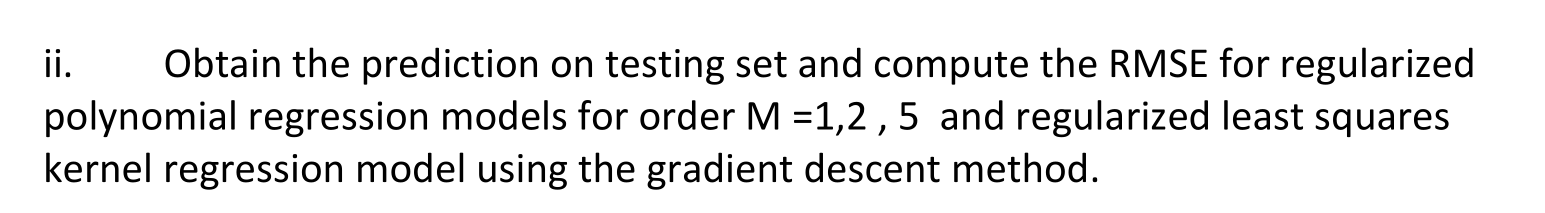

In [ ]:
full_data = xTrain.shape[0]
w_poliMini1, w_poliMini1, rmse_poliMini1 = train_pol(xTrain, yTrain, bs=full_data, degrees=[1], epochs=400000,lr=0.01)
w_poliMini2, w_poliMini2, rmse_poliMini2 = train_pol(xTrain, yTrain, bs=full_data, degrees=[2], epochs=400000,lr=0.01)
w_poliMini5, w_poliMini5, rmse_poliMini5 = train_pol(xTrain, yTrain, bs=full_data, degrees=[2,3,4,5], epochs=400000,lr=0.01)
rmse_poliMini1[-1], rmse_poliMini2[-1], rmse_poliMini5[-1]

(0.7637667801770752, 0.5896631317654156, 0.4916510549124644)

In [ ]:
rmse_KRMini1 = train_KR(xTrain, yTrain, bs=full_data, epochs=100,lr=0.0000001)
rmse_KRMini1[-1]

array([[0.77188537]])

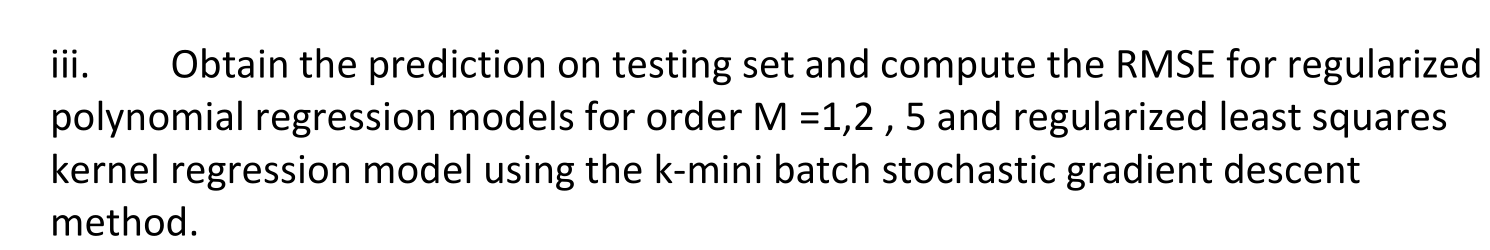

In [ ]:
w_poliMini1, w_poliMini1, rmse_poliMini1 = train_pol(xTrain, yTrain, bs=100, degrees=[1], epochs=400000,lr=0.01)
w_poliMini2, w_poliMini2, rmse_poliMini2 = train_pol(xTrain, yTrain, bs=100, degrees=[2], epochs=400000,lr=0.01)
w_poliMini5, w_poliMini5, rmse_poliMini5 = train_pol(xTrain, yTrain, bs=100, degrees=[2,3,4,5], epochs=400000,lr=0.01)
rmse_poliMini1[-1], rmse_poliMini2[-1], rmse_poliMini5[-1]

(0.7637764235279999, 0.5896734761248619, 0.35803325804624503)

In [ ]:
rmse_KRMini1 = train_KR(xTrain, yTrain, bs=100, epochs=100,lr=0.0000001)
rmse_KRMini1[-1]

array([[0.7842344]])

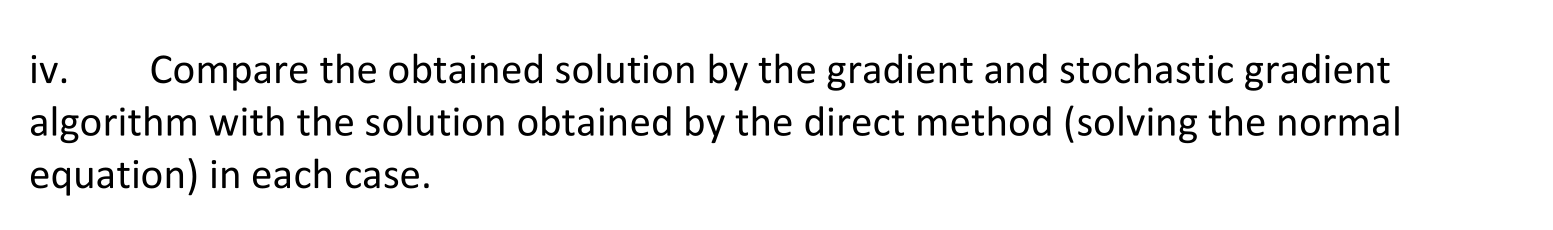

Direct method ie. normal method give solution by just solving system of equation so it give direct value of parameters like w and b. While gredient algorithm is iterative one, it takes multiple iterations to reach to convergence.
Using direct method i got rsme around 0.4 while using gred decent can also result same output by parameter tuning.

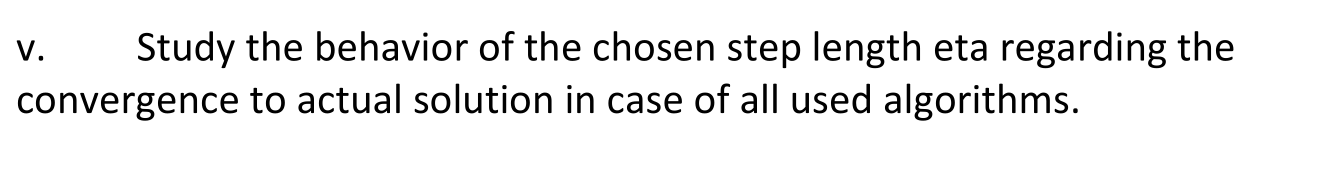

I tried different values of eta ie step length and observed that it overshout the minima when i take 0.0001 as learning rate and 1000 epoch, also I found that if i take small value of theta ie below < 0.001, i am getting matrix multiplication overflow, matrix squre overflow, which was occuring due to many operations consecutively while training.